In [14]:
#Se necessário:
#%pip install pandas
#%pip install tensorflow
#%pip install pillow
#%pip install matplotlib

In [1]:
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
from PIL import Image
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

tf.compat.v1.disable_eager_execution()

def exponential_decay_schedule(initial_lr=1e-3, decay_factor=0.9):
    """
    Wrapper function to create a LearningRateScheduler with exponential decay schedule.
    """
    def schedule(epoch):
        return initial_lr * decay_factor ** epoch

    return LearningRateScheduler(schedule)


class VariationalAutoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides, z_dim):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.build()

    def build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )
            
            x = conv_layer(x)

            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        encoder_output = Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)


        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )
            
            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:

                x = LeakyReLU()(x)

            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        # FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def sampling(self, args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    def compile_model(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
            return r_loss * r_loss_factor
        
        def vae_kl_loss(a, b):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)
            return kl_loss
        
        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return r_loss + kl_loss
        
        optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])


    def train(self, x_train, batch_size, epochs, print_history_bool = True, lr_decay= 0.9):

            lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay)

            callbacks_list = [lr_sched]

            history = self.model.fit(x_train, x_train, batch_size = batch_size, shuffle = True,
                        epochs = epochs, callbacks = callbacks_list)

            if print_history:
                plt.plot(history.history['loss'])
                plt.plot(history.history['vae_r_loss'])
                plt.plot(history.history['vae_kl_loss'])
                plt.title('Loss progression')
                plt.ylabel('Loss')
                plt.xlabel('Epoch')
                plt.legend(['VAE loss', 'Reconstruction', 'KL'], loc='upper right')
                plt.show()
            return history


In [2]:
df_movies = pd.read_csv("C:\\Users\\xxsly\\PycharmProjects\\APRP\\df_aux_movies.csv")
print(df_movies.head())

   movieId                                title  \
0        1                     Toy Story (1995)   
1       10                     GoldenEye (1995)   
2      100                     City Hall (1996)   
3     1000                       Curdled (1996)   
4     1001  Associate, The (Associé, L') (1979)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                    Action|Adventure|Thriller  
2                               Drama|Thriller  
3                                        Crime  
4                                       Comedy  


In [3]:
def load_poster_images(c):
    images = []
    filenames = []
    for f in os.listdir(c):
        if f.endswith('.jpg'):
            img = Image.open(os.path.join(c, f))
            if img is not None:
                img_array = np.array(img)
                if img_array.shape[2] == 4:  # Se tiver 4 canais - img 629 por ex tem
                    img_array = img_array[:, :, :3]  # Deixar só os 3 primeiros canais (RGB)
                if img_array.shape == (128, 128, 3):
                    images.append(img_array)
                    filenames.append(f)
                else:
                    print(f"A imagem {f} tem dimensões incorretas: {img_array.shape}")

    if len(images) == 0:
        print("Nenhuma imagem válida encontrada.")
        return None, None

    imgs = np.stack(images) 
    return imgs.astype('float32') / 255.0, filenames

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 128, 128, 32  896         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 32  0           ['encoder_conv_0[0][0]']         
                                )                                                             

c:\Users\xxsly\anaconda3\envs\PycharmProjects\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 28s 28ms/sample - loss: 11.2376 - vae_r_loss: 11.1809 - vae_kl_loss: 0.0567 - lr: 5.0000e-04
Epoch 2/50
1000/1000 [==============================] - 26s 26ms/sample - loss: 10.0741 - vae_r_loss: 9.3961 - vae_kl_loss: 0.6780 - lr: 4.5000e-04
Epoch 3/50
1000/1000 [==============================] - 29s 29ms/sample - loss: 9.2214 - vae_r_loss: 8.2789 - vae_kl_loss: 0.9425 - lr: 4.0500e-04
Epoch 4/50
1000/1000 [==============================] - 27s 27ms/sample - loss: 9.0148 - vae_r_loss: 8.0429 - vae_kl_loss: 0.9719 - lr: 3.6450e-04
Epoch 5/50
1000/1000 [==============================] - 41s 41ms/sample - loss: 8.8609 - vae_r_loss: 7.8047 - vae_kl_loss: 1.0562 - lr: 3.2805e-04
Epoch 6/50
1000/1000 [==============================] - 43s 43ms/sample - loss: 8.7317 - vae_r_loss: 7.6814 - vae_kl_loss: 1.0503 - lr: 2.9525e-04
Epoch 7/50
1000/1000 [==============================] - 35s 35ms/sample - loss: 8.7202 - vae_

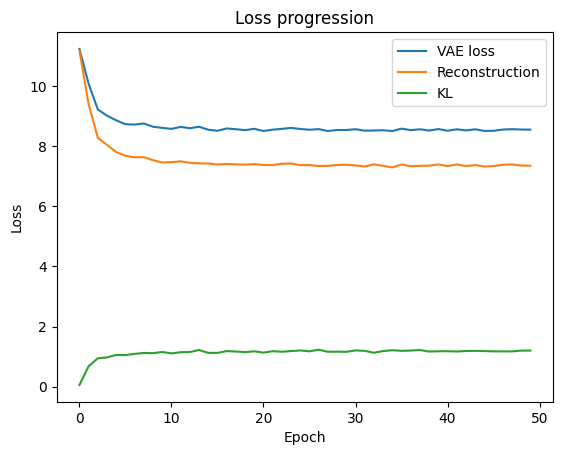

In [4]:
c = "C:\\Users\\xxsly\\PycharmProjects\\APRP\\Post_1000"
posters, filenames = load_poster_images(c)

vae = VariationalAutoencoder(
    input_dim = posters.shape[1:]
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

vae.encoder.summary()
vae.decoder.summary()

# Setting the parameters
learning_rate = 0.0005
reconstruction_loss_factor = 100
batch_size = 32
epochs = 50
print_history = True

vae.compile_model(learning_rate, reconstruction_loss_factor)

history = vae.train(posters, batch_size = batch_size, epochs = epochs, print_history_bool= print_history)

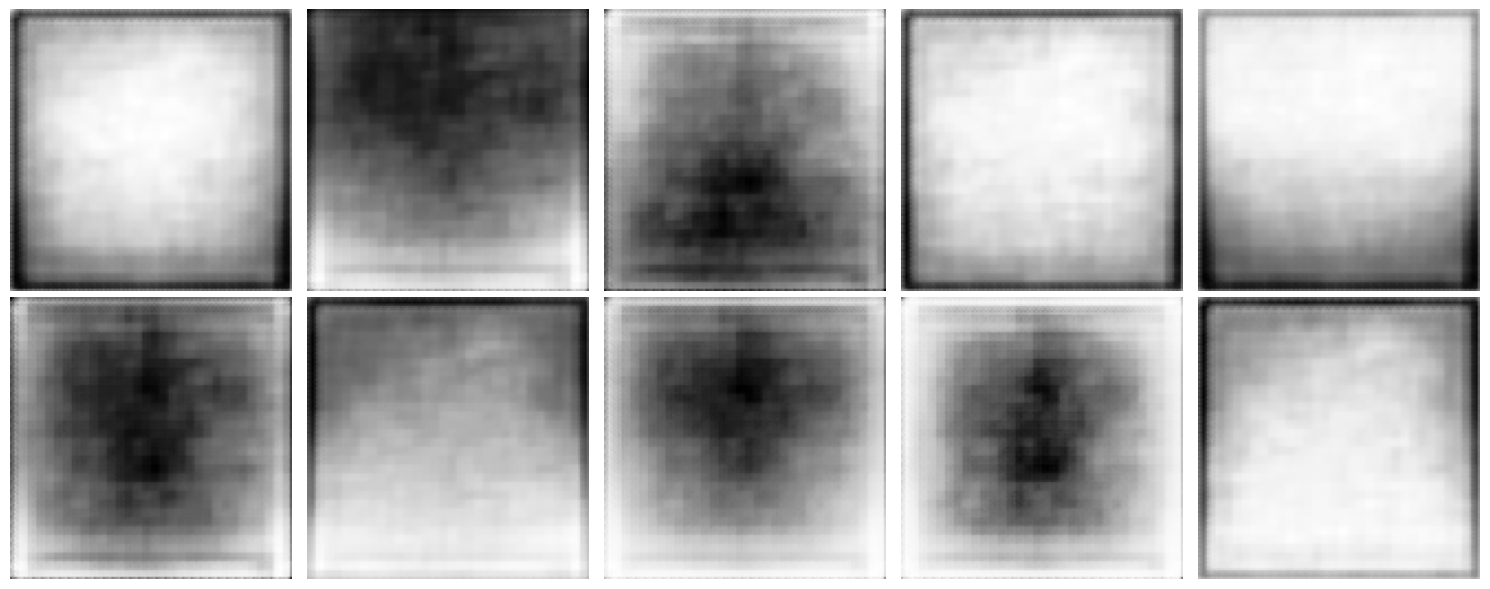

In [16]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, vae.z_dim))
generated_posters = vae.decoder.predict(latent_vectors)

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i].squeeze(), cmap = 'Greys')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Obter o ID da imagem
poster_ids = [int(f.split('.')[0]) for f in filenames]

# One-hot encoding dos genres
genres_final = set()
for genres in df_movies['genres'].str.split('|'):
    genres_final.update(genres)

# Converter genres_final numa lista
genres_final = list(genres_final)

# Para cada genre, criamos uma coluna no df_movies onde todos os valores nessa coluna são 0
for genre in genres_final:
    df_movies[genre.strip()] = 0

# Percorremos as linhas do df e na coluna do respetivo genre colocamos 1 para saber que é esse o genre daquele movieID
for ind, row in df_movies.iterrows():
    genres = row['genres'].split('|')
    for genre in genres:
        df_movies.at[ind, genre.strip()] = 1

df_movies.drop(columns=['genres'], inplace=True)

# Extrair os genres one-hot para o training
genres_one_hot = df_movies[genres_final].values

# Reordenar posters e genres_on_hot para a correspondência
poster_order = [poster_ids.index(mid) for mid in df_movies['movieId']]
posters = posters[poster_order]
genres_one_hot = genres_one_hot[poster_order]

In [13]:
class ConditionalVariationalAutoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, num_labels):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.num_labels = num_labels

        self._build()

    def _build(self):

        ### ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')
        labels_input = Input(shape=(self.num_labels,), name='labels_input')

        x = encoder_input
        # Converter etiquetas para uma forma compatível e concatená-las com a entrada
        labels_dense = Dense(np.prod(self.input_dim), activation='relu')(labels_input)
        labels_reshaped = Reshape(self.input_dim)(labels_dense)
        x = Concatenate(axis=-1)([x, labels_reshaped])

        for i in range(len(self.encoder_conv_filters)):
            x = Conv2D(filters=self.encoder_conv_filters[i], kernel_size=self.encoder_conv_kernel_size[i],
                       strides=self.encoder_conv_strides[i], padding='same', name='encoder_conv_' + str(i))(x)
            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)

        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model([encoder_input, labels_input], encoder_output, name='encoder')

        ### DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        labels_input_decoder = Input(shape=(self.num_labels,), name='labels_input_decoder')

        x = Concatenate()([decoder_input, labels_input_decoder])
        x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
        x = Reshape(shape_before_flattening)(x)

        for i in range(len(self.decoder_conv_t_filters)):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i], kernel_size=self.decoder_conv_t_kernel_size[i],
                                strides=self.decoder_conv_t_strides[i], padding='same', name='decoder_conv_t_' + str(i))(x)
            if i < len(self.decoder_conv_t_filters) - 1:
                x = LeakyReLU()(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        self.decoder = Model([decoder_input, labels_input_decoder], decoder_output, name='decoder')

        ### CONDITIONAL VAE MODEL
        model_input = [encoder_input, labels_input]
        model_output = self.decoder([encoder_output, labels_input])
        self.model = Model(model_input, model_output, name='cvae')

    def compile_model(self, learning_rate=0.0005):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

        def vae_kl_loss(y_true, y_pred):
            return -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

        def vae_loss(y_true, y_pred):
            return vae_r_loss(y_true, y_pred) + vae_kl_loss(y_true, y_pred)

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

In [29]:
cvae = ConditionalVariationalAutoencoder(
    input_dim=(128, 128, 3),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    decoder_conv_t_filters=[64, 64, 32, 3],
    decoder_conv_t_kernel_size=[3, 3, 3, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    z_dim=2,
    num_labels=genres_one_hot.shape[1]
)

cvae.compile_model(learning_rate=0.0005)

history = cvae.model.fit([posters, genres_one_hot], posters, epochs=50, batch_size=32)

c:\Users\xxsly\anaconda3\envs\PycharmProjects\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 31s 31ms/sample - loss: 0.1435 - vae_r_loss: 0.1121 - vae_kl_loss: 0.0315
Epoch 2/50
1000/1000 [==============================] - 32s 32ms/sample - loss: 0.1078 - vae_r_loss: 0.1068 - vae_kl_loss: 0.0010
Epoch 3/50
1000/1000 [==============================] - 30s 30ms/sample - loss: 0.1045 - vae_r_loss: 0.1043 - vae_kl_loss: 1.7922e-04
Epoch 4/50
1000/1000 [==============================] - 36s 36ms/sample - loss: 0.1034 - vae_r_loss: 0.1033 - vae_kl_loss: 1.1238e-04
Epoch 5/50
1000/1000 [==============================] - 30s 30ms/sample - loss: 0.1028 - vae_r_loss: 0.1027 - vae_kl_loss: 9.6922e-05
Epoch 6/50
1000/1000 [==============================] - 31s 31ms/sample - loss: 0.1018 - vae_r_loss: 0.1017 - vae_kl_loss: 7.3111e-05
Epoch 7/50
1000/1000 [==============================] - 32s 32ms/sample - loss: 0.1024 - vae_r_loss: 0.1023 - vae_kl_loss: 6.9685e-05
Epoch 8/50
1000/1000 [==========================

In [34]:
print(genres_final)

['Drama', 'Film-Noir', 'Crime', 'Documentary', 'Children', 'Adventure', 'Romance', 'Action', 'Musical', 'Animation', 'IMAX', 'Fantasy', 'Mystery', 'Horror', 'Comedy', 'War', 'Sci-Fi', 'Thriller', 'Western']


c:\Users\xxsly\anaconda3\envs\PycharmProjects\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


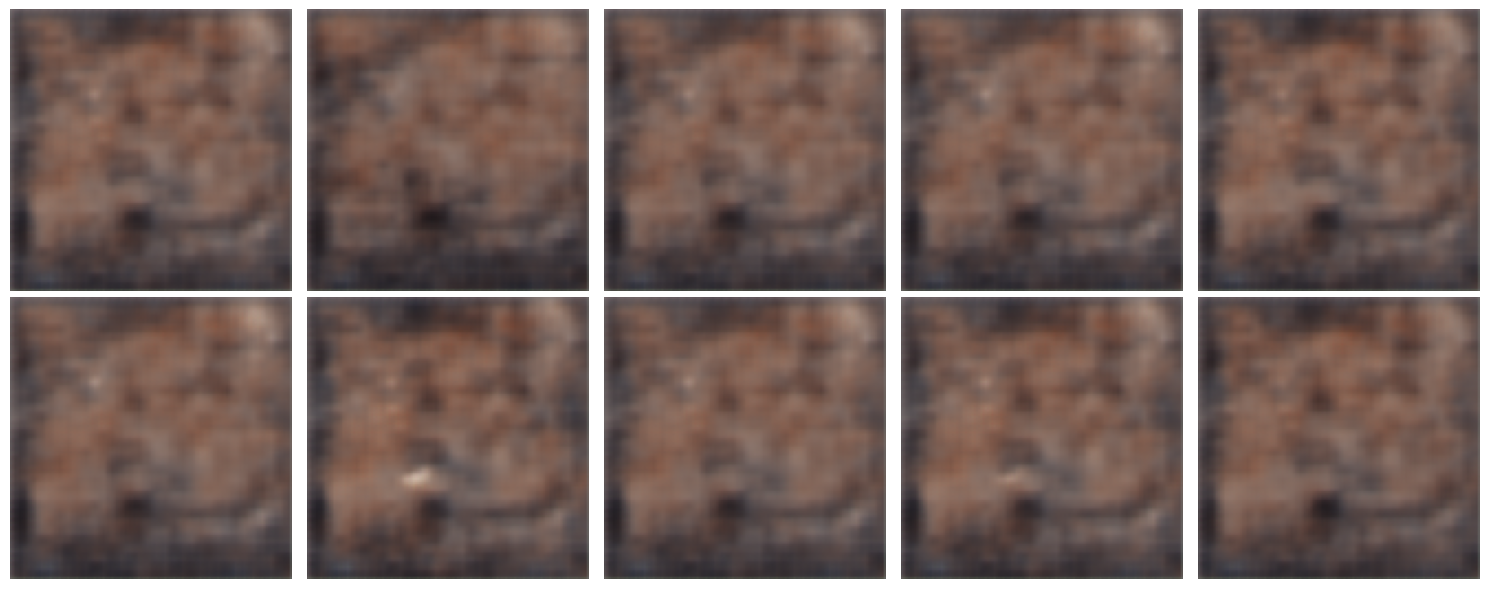

In [30]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

# Utilizar apenas a coluna do genre Action
action_genre_idx = list(genres_final).index('Action')
action_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
action_labels[:, action_genre_idx] = 1

reconst = cvae.decoder.predict([latent_vectors, action_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(reconst[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


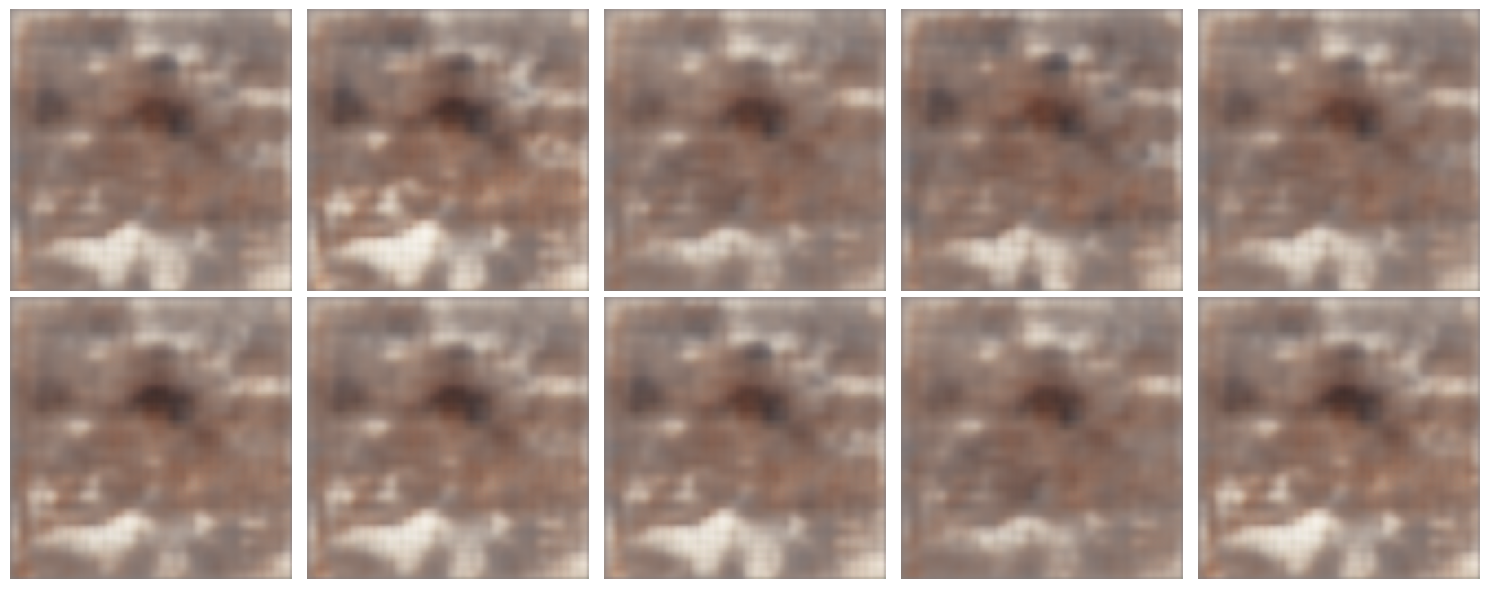

In [33]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

action_genre_idx = list(genres_final).index('Adventure')
action_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
action_labels[:, action_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, action_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


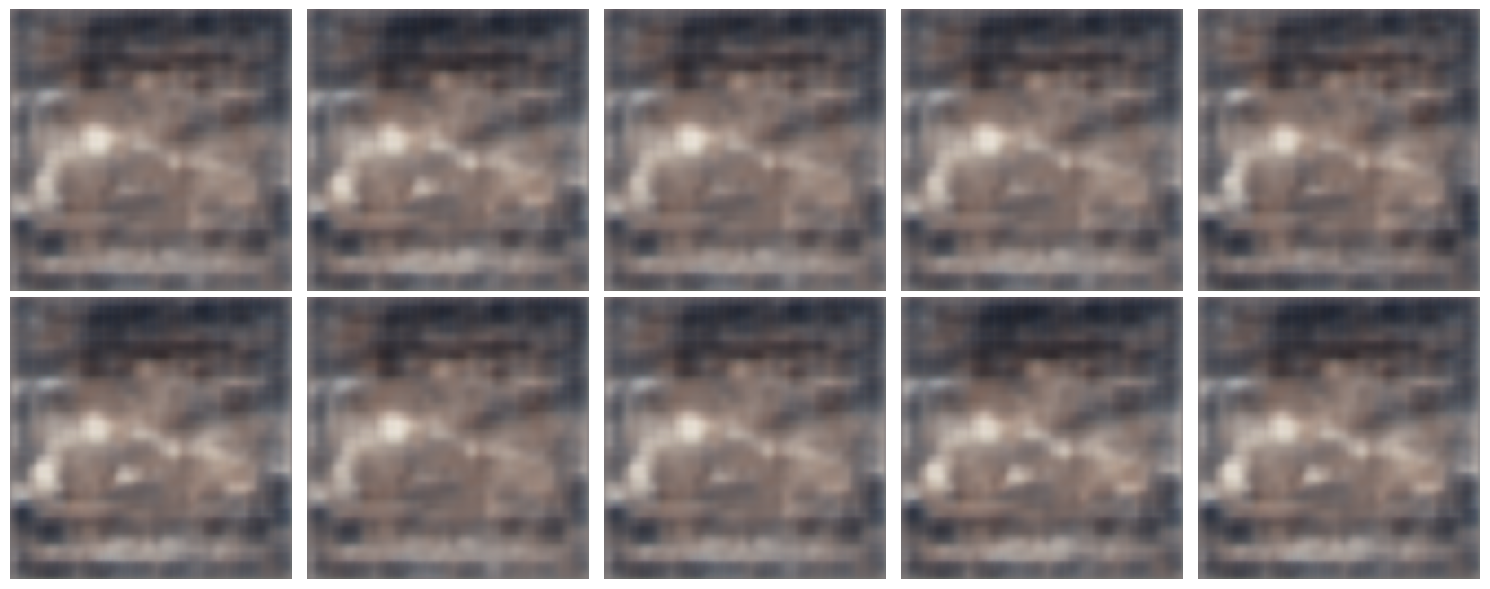

In [38]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

animation_genre_idx = list(genres_final).index('Animation')
animation_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
animation_labels[:, animation_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, animation_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


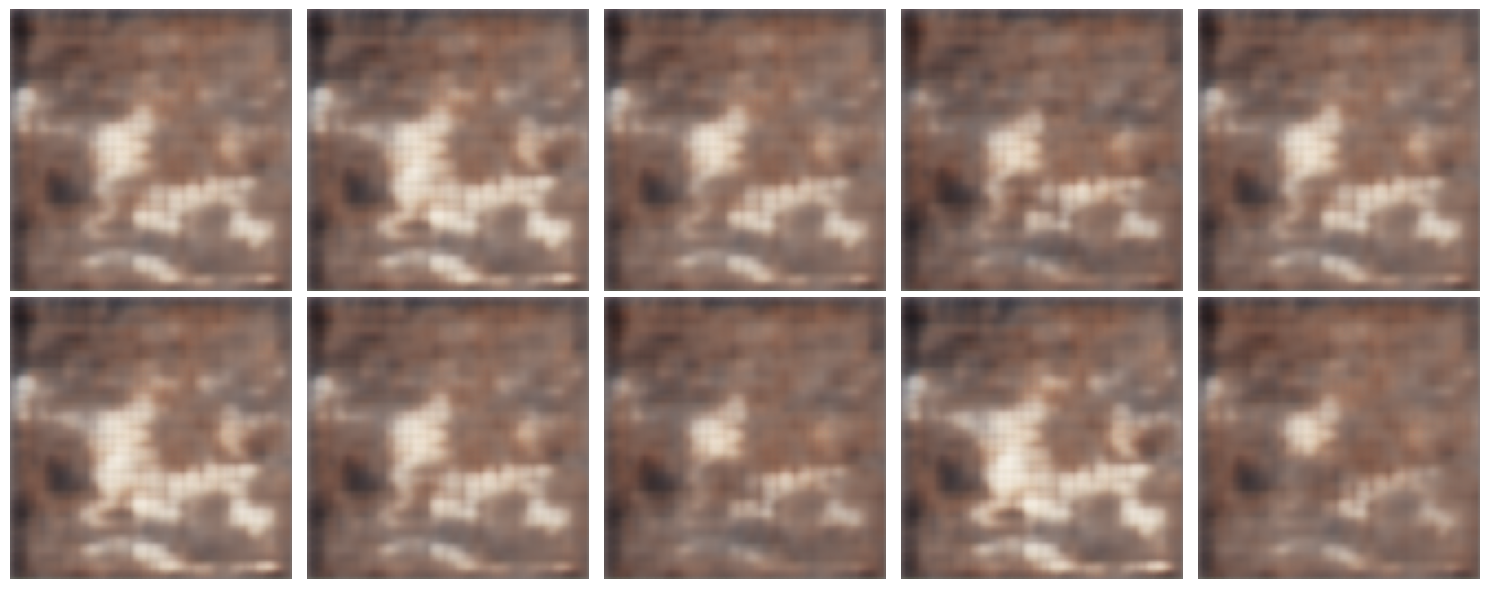

In [40]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))


fantasy_genre_idx = list(genres_final).index('Fantasy')
fantasy_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
fantasy_labels[:, fantasy_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, fantasy_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


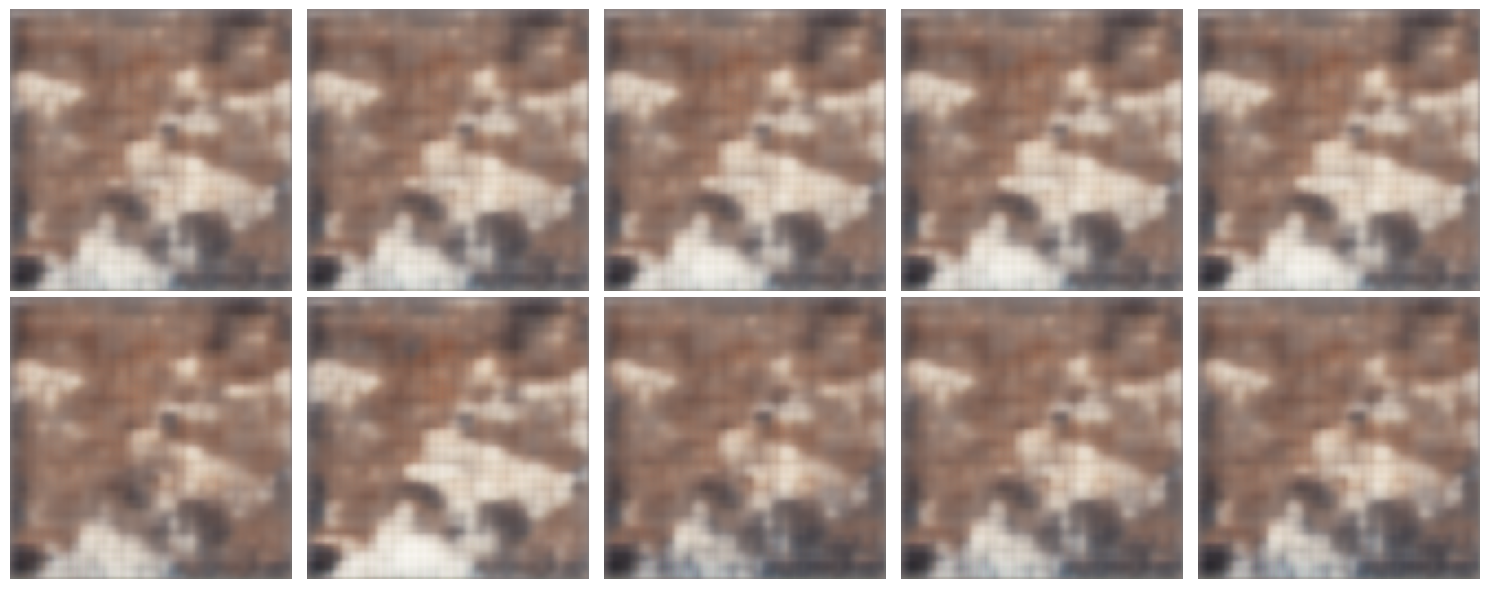

In [42]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

mystery_genre_idx = list(genres_final).index('Mystery')
mystery_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
mystery_labels[:, mystery_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, mystery_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


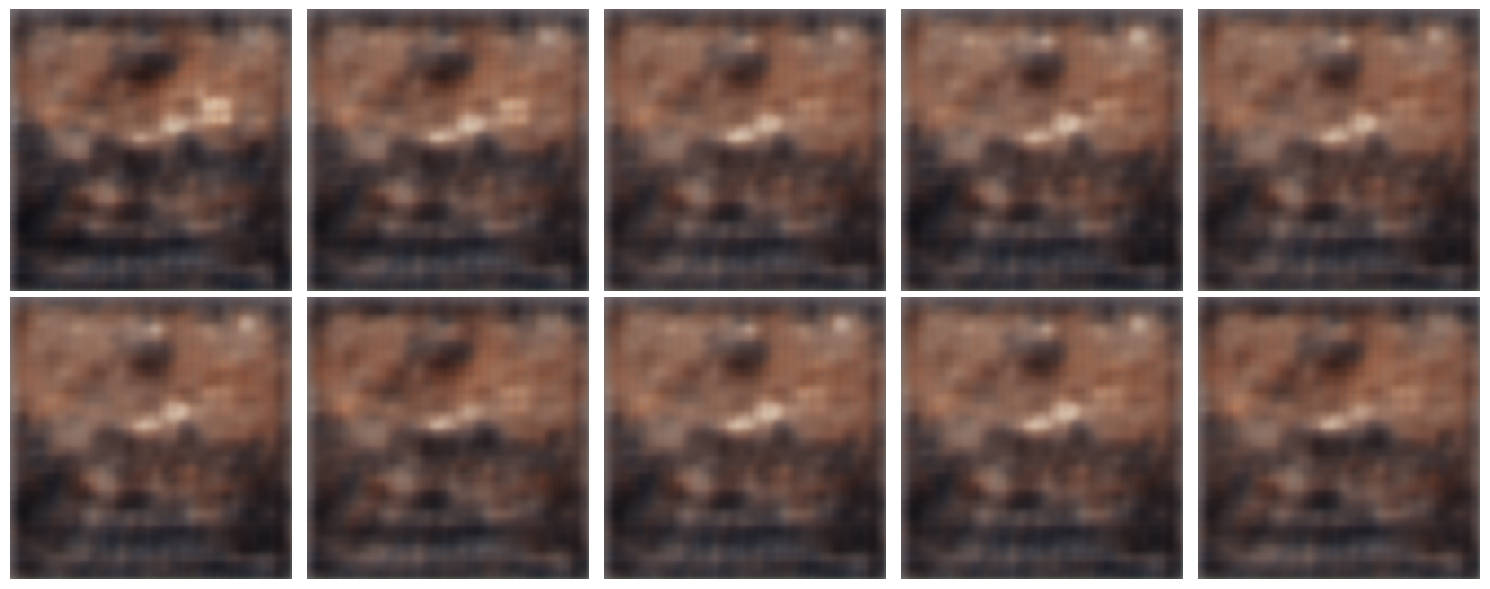

In [43]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))


war_genre_idx = list(genres_final).index('War')
war_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
war_labels[:, war_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, war_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


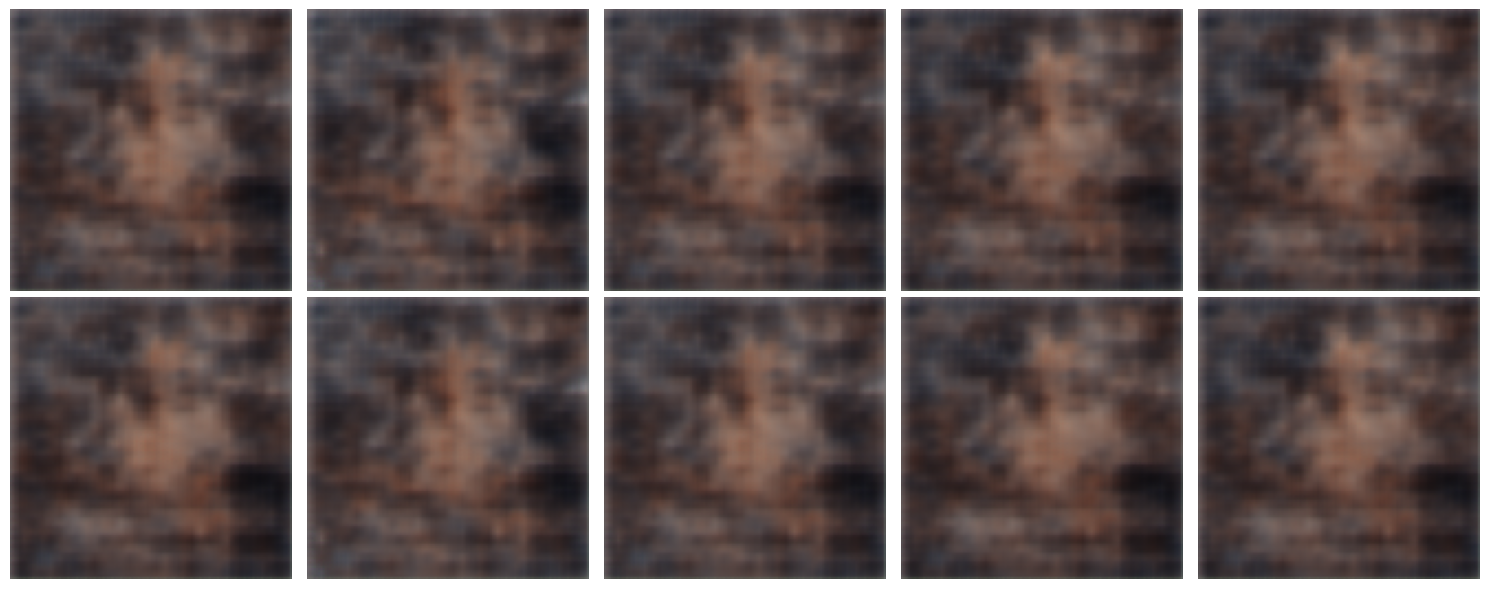

In [44]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

horror_genre_idx = list(genres_final).index('Horror')
horror_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
horror_labels[:, horror_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, horror_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


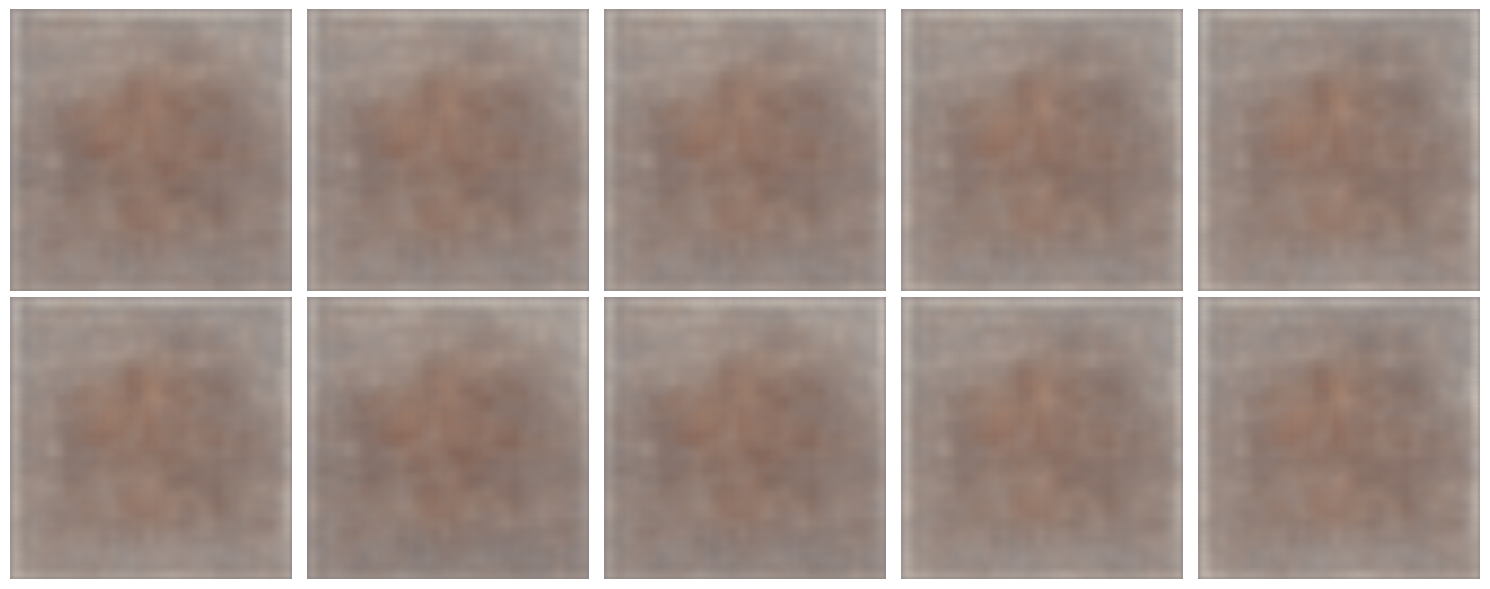

In [45]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))


comedy_genre_idx = list(genres_final).index('Comedy')
comedy_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
comedy_labels[:, comedy_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, comedy_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


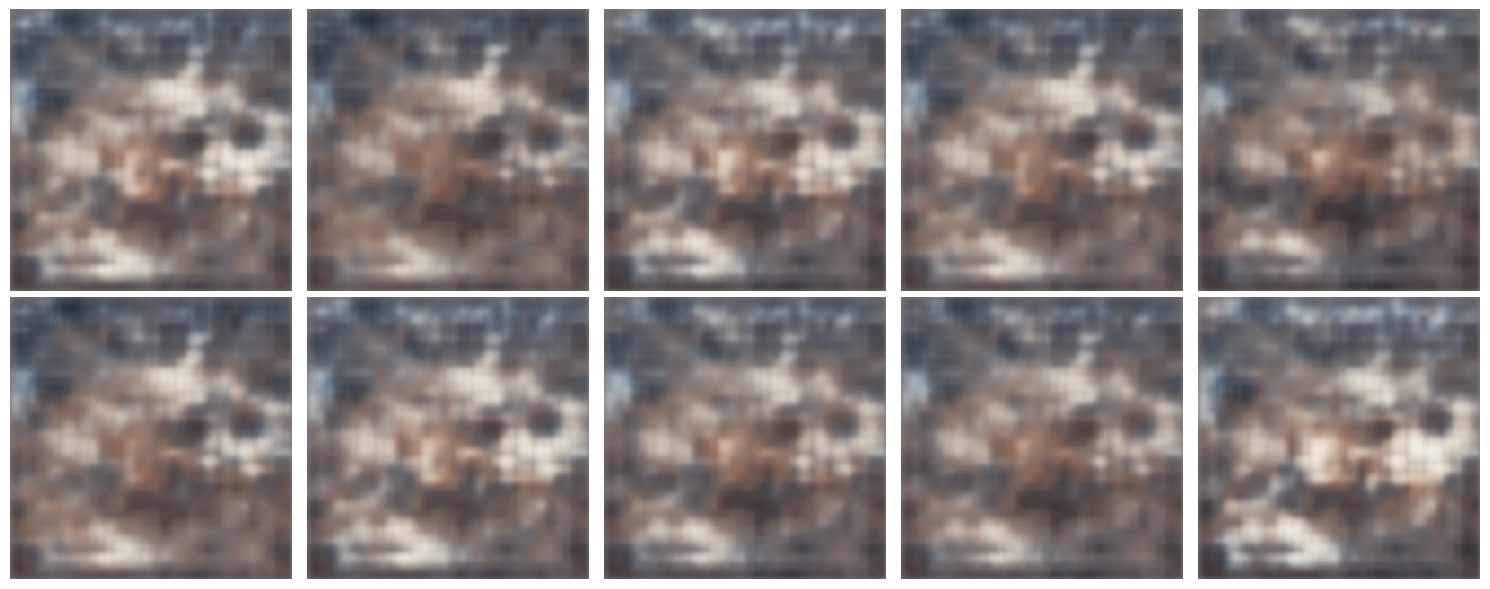

In [46]:
num_samples = 10
latent_vectors = np.random.normal(size=(num_samples, cvae.z_dim))

scifi_genre_idx = list(genres_final).index('Sci-Fi')
scifi_labels = np.zeros((num_samples, genres_one_hot.shape[1]))
scifi_labels[:, scifi_genre_idx] = 1

generated_posters = cvae.decoder.predict([latent_vectors, scifi_labels])

# Visualizar os posters gerados
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_posters[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
